# Imports

In [1]:
# Basics
import numpy as np
import pandas as pd
import os

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Models and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Custom
import env
import wrangle_prep

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Aquire

- Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

- Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

- Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values. 

In [2]:
query = '''
        SELECT prop.*, 
               pred.logerror, 
               pred.transactiondate, 
               air.airconditioningdesc, 
               arch.architecturalstyledesc, 
               build.buildingclassdesc, 
               heat.heatingorsystemdesc, 
               landuse.propertylandusedesc, 
               story.storydesc, 
               construct.typeconstructiondesc 
               
        FROM properties_2017 prop  
                INNER JOIN (SELECT parcelid,
                                  logerror,
                                  Max(transactiondate) transactiondate 
        FROM predictions_2017 
                GROUP BY parcelid, logerror) pred USING (parcelid)
                
        LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
        LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
        LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
        LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
        LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
        LEFT JOIN storytype story USING (storytypeid) 
        LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
        
        WHERE prop.latitude IS NOT NULL 
        AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
        '''

url = f"mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow"

df = pd.read_sql(query, url)

In [3]:
df = df.drop_duplicates('id')

In [4]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,None,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,None,NaN,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,None,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,None,NaN,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,None,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,None,NaN,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,None,NaN,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,None,NaN,6.037124e+13,0.006940,2017-01-01,Central,None,None,Central,Condominium,None,None


In [5]:
df.shape

(77381, 68)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77381 non-null  int64  
 1   parcelid                      77381 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77381 non-null  float64
 6   bedroomcnt                    77381 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49672 non-null  float64
 9   calculatedbathnbr             76772 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77185 non-null  float64
 13  f

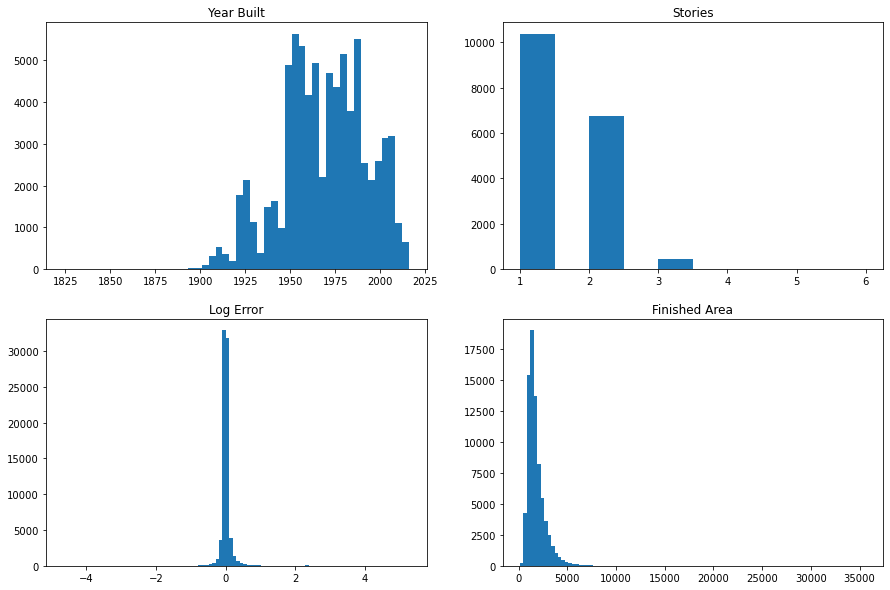

In [7]:
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.hist(df.yearbuilt, bins = 50)
plt.title('Year Built')

plt.subplot(222)
plt.hist(df.numberofstories, bins = 10)
plt.title('Stories')

plt.subplot(223)
plt.hist(df.logerror, bins = 100)
plt.title('Log Error')

plt.subplot(224)
plt.hist(df.calculatedfinishedsquarefeet, bins = 100)
plt.title('Finished Area')

plt.show()

In [8]:
df.isnull().sum().sort_values()

id                                  0
propertylandusedesc                 0
transactiondate                     0
logerror                            0
assessmentyear                      0
roomcnt                             0
regionidcounty                      0
rawcensustractandblock              0
propertylandusetypeid               0
longitude                           0
latitude                            0
fips                                0
propertycountylandusecode           0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
taxvaluedollarcnt                   1
landtaxvaluedollarcnt               2
taxamount                           5
regionidzip                        50
structuretaxvaluedollarcnt        112
calculatedfinishedsquarefeet      196
censustractandblock               244
yearbuilt                         263
fullbathcnt                       609
calculatedbathnbr                 609
regionidcity

- Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values. 

In [9]:
# function for null metrics
def column_nulls(df):
    missing = df.isnull().sum()
    rows = df.shape[0]
    missing_percent = (round((missing / rows), 5)*100)
    cols_missing = pd.DataFrame({'missing_count': missing, 'missing_percent': missing_percent})
    return cols_missing

In [10]:
null_metrics = column_nulls(df)

null_metrics.sort_values('missing_percent', ascending=False)

,missing_count,missing_percent
buildingclassdesc,77366,99.981
buildingclasstypeid,77366,99.981
finishedsquarefeet13,77340,99.947
storytypeid,77331,99.935
basementsqft,77331,99.935
storydesc,77331,99.935
yardbuildingsqft26,77311,99.910
fireplaceflag,77209,99.778
architecturalstyletypeid,77175,99.734
architecturalstyledesc,77175,99.734


- Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values. 

In [11]:
df2 = pd.DataFrame(df.isnull().sum(axis =1), columns = ['num_cols_missing']).reset_index().groupby('num_cols_missing').count().reset_index().rename(columns = {'index': 'num_rows'})

df2['percent_of_columns_missing'] = df2.num_cols_missing/df.shape[1]
df2.head()

,num_cols_missing,num_rows,percent_of_columns_missing
0,23,2,0.338235
1,24,13,0.352941
2,25,24,0.367647
3,26,65,0.382353
4,27,316,0.397059


In [12]:
def columns_missing(df):
    df2 = pd.DataFrame(df.isnull().sum(axis =1), columns = ['num_cols_missing']).reset_index()\
    .groupby('num_cols_missing').count().reset_index().\
    rename(columns = {'index': 'num_rows' })
    df2['pct_cols_missing'] = (round(df2.num_cols_missing/df.shape[1], 5)*100)
    return df2

In [13]:
columns_missing(df).sort_values(by = ['pct_cols_missing'], ascending = False).head(10)

,num_cols_missing,num_rows,pct_cols_missing
25,48,3,70.588
24,47,3,69.118
23,46,5,67.647
22,45,50,66.176
21,44,78,64.706
20,43,28,63.235
19,42,23,61.765
18,41,29,60.294
17,40,230,58.824
16,39,285,57.353


- Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [14]:
df.unitcnt.value_counts(dropna = False)

1.0      47293
NaN      26818
2.0       2018
4.0        723
3.0        525
45.0         1
42.0         1
6.0          1
237.0        1
Name: unitcnt, dtype: int64

In [15]:
# gotta pull only single unit

single_unit = [261, 262, 263, 264, 266, 268, 273, 276, 279]

df = df[df.propertylandusetypeid.isin(single_unit)]

df.shape

(71694, 68)

In [16]:
# Refine
df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & (df.unitcnt<=1)|df.unitcnt.isnull()]
df.shape

(71421, 68)

- Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row)

In [17]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .70):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [18]:
df = handle_missing_values(df)

In [19]:
df.shape

(71353, 34)

In [20]:
null_metrics = column_nulls(df)

null_metrics.sort_values('missing_percent', ascending=False)

,missing_count,missing_percent
buildingqualitytypeid,26609,37.292
unitcnt,26303,36.863
propertyzoningdesc,26266,36.811
heatingorsystemdesc,25023,35.069
heatingorsystemtypeid,25023,35.069
lotsizesquarefeet,8033,11.258
regionidcity,1324,1.856
finishedsquarefeet12,261,0.366
censustractandblock,208,0.292
calculatedbathnbr,123,0.172


In [21]:
df.isnull().sum()

id                                  0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           26609
calculatedbathnbr                 123
calculatedfinishedsquarefeet       85
finishedsquarefeet12              261
fips                                0
fullbathcnt                       123
heatingorsystemtypeid           25023
latitude                            0
longitude                           0
lotsizesquarefeet                8033
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc              26266
rawcensustractandblock              0
regionidcity                     1324
regionidcounty                      0
regionidzip                        40
roomcnt                             0
unitcnt                         26303
yearbuilt                         118
structuretaxvaluedollarcnt         79
taxvaluedollarcnt                   1
assessmentye

In [22]:
# used column desc to decided what to drop (https://docs.google.com/spreadsheets/d/1Afpo71HUAARrtmbvwQ08fSzSkDlvFoCNiTfgvvrIehs/edit#gid=1781065348)

columns_to_drop = ['id', 'heatingorsystemdesc', 'heatingorsystemtypeid', 'finishedsquarefeet12', 'calculatedbathnbr', 'propertycountylandusecode', 'censustractandblock', 'fullbathcnt', 'propertylandusetypeid', 'propertylandusedesc', 'propertyzoningdesc', 'unitcnt']

In [23]:
df = df.drop(columns=columns_to_drop)
df.isnull().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           26609
calculatedfinishedsquarefeet       85
fips                                0
latitude                            0
longitude                           0
lotsizesquarefeet                8033
rawcensustractandblock              0
regionidcity                     1324
regionidcounty                      0
regionidzip                        40
roomcnt                             0
yearbuilt                         118
structuretaxvaluedollarcnt         79
taxvaluedollarcnt                   1
assessmentyear                      0
landtaxvaluedollarcnt               1
taxamount                           5
logerror                            0
transactiondate                     0
dtype: int64

In [24]:
# largest group of nulls
df.buildingqualitytypeid.value_counts(dropna=False)

NaN     26609
8.0     13370
6.0     12638
4.0      8209
7.0      5503
9.0      2109
5.0      1497
11.0      844
10.0      302
3.0       147
12.0      113
1.0         9
2.0         3
Name: buildingqualitytypeid, dtype: int64

In [25]:
# considering its a categorical column, i'd be comfortable filling nulls with the median value
# nulls only represent roughly 1/3 of the data
df.buildingqualitytypeid.median(), df.shape

(6.0, (71353, 22))

In [26]:
# get ride of nulls for buildingqualitytypeid
df.buildingqualitytypeid.fillna(6.0, inplace= True)
df.isnull().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedfinishedsquarefeet      85
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet               8033
rawcensustractandblock             0
regionidcity                    1324
regionidcounty                     0
regionidzip                       40
roomcnt                            0
yearbuilt                        118
structuretaxvaluedollarcnt        79
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
logerror                           0
transactiondate                    0
dtype: int64

<AxesSubplot:>

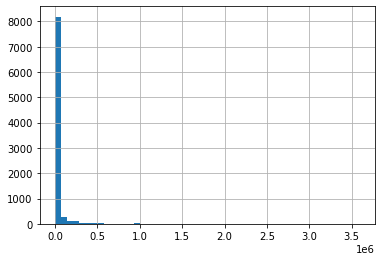

In [27]:
# lotsizesquarefeet is next largest
sample = df.sample(10000)

sample.lotsizesquarefeet.hist(bins=50)

In [28]:
# median should suffice
df.lotsizesquarefeet.median()

7319.0

In [31]:
# replace nulls
df.lotsizesquarefeet.fillna(7313, inplace=True)

df.isnull().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedfinishedsquarefeet      85
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet                  0
rawcensustractandblock             0
regionidcity                    1324
regionidcounty                     0
regionidzip                       40
roomcnt                            0
yearbuilt                        118
structuretaxvaluedollarcnt        79
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
logerror                           0
transactiondate                    0
dtype: int64

In [32]:
df.dropna(inplace=True)
df.shape

(69828, 22)

In [33]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,1286.0,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01
1,17052889,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,2061.0,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01
2,14186244,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,1286.0,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01
3,12177905,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,3101.0,96330.0,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01
4,10887214,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,6.037124e+07,12447.0,3101.0,96451.0,0.0,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,0.006940,2017-01-01


In [35]:
# look at data to find columns with outrageous outliers
df.describe()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror
count,6.982800e+04,69828.000000,69828.000000,69828.000000,69828.000000,69828.000000,6.982800e+04,6.982800e+04,6.982800e+04,6.982800e+04,69828.000000,69828.000000,69828.000000,69828.000000,69828.000000,6.982800e+04,6.982800e+04,69828.0,6.982800e+04,69828.000000,69828.000000
mean,1.300606e+07,2.263154,3.012187,6.362491,1746.473062,6049.318325,3.400256e+07,-1.181943e+08,2.766842e+04,6.049616e+07,33446.219053,2499.713052,96610.965172,1.585754,1969.048634,1.868658e+05,4.871665e+05,2016.0,3.003008e+05,5928.779063,0.016870
std,2.123851e+06,0.939974,1.004855,1.370420,924.497803,20.845490,2.679349e+05,3.611244e+05,1.189385e+05,2.068984e+05,46447.598931,814.717028,3994.878889,2.905295,23.018195,2.308617e+05,6.335988e+05,0.0,4.600523e+05,7358.939969,0.166612
min,1.071186e+07,0.000000,0.000000,1.000000,128.000000,6037.000000,3.333953e+07,-1.194753e+08,2.360000e+02,6.037101e+07,3491.000000,1286.000000,95982.000000,0.000000,1878.000000,4.400000e+01,3.254000e+03,2016.0,1.610000e+02,19.920000,-4.655420
25%,1.154674e+07,2.000000,2.000000,6.000000,1165.000000,6037.000000,3.380408e+07,-1.184101e+08,6.000000e+03,6.037311e+07,12447.000000,1286.000000,96206.000000,0.000000,1954.000000,8.308975e+04,2.031895e+05,2016.0,8.264675e+04,2672.417500,-0.023570
50%,1.258818e+07,2.000000,3.000000,6.000000,1510.000000,6037.000000,3.401397e+07,-1.181640e+08,7.313000e+03,6.037621e+07,25218.000000,3101.000000,96411.000000,0.000000,1970.000000,1.341075e+05,3.553370e+05,2016.0,2.036455e+05,4386.160000,0.006676
75%,1.425614e+07,3.000000,4.000000,7.000000,2054.000000,6059.000000,3.417415e+07,-1.179138e+08,1.076825e+04,6.059052e+07,45457.000000,3101.000000,96989.000000,0.000000,1987.000000,2.142190e+05,5.652042e+05,2016.0,3.681000e+05,6808.255000,0.038434
max,1.629608e+08,13.000000,11.000000,12.000000,21929.000000,6111.000000,3.481877e+07,-1.175723e+08,6.971010e+06,6.111009e+07,396556.000000,3101.000000,399675.000000,15.000000,2016.000000,1.142179e+07,2.538125e+07,2016.0,2.233550e+07,290998.060000,5.262999


<AxesSubplot:>

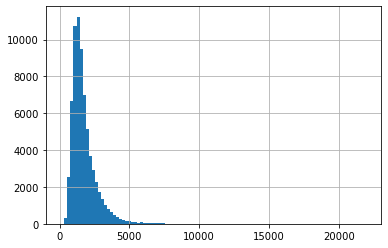

In [37]:
# calculatedfinishedsquarefeet
df.calculatedfinishedsquarefeet.hist(bins=100)

# remove over 9,000

<AxesSubplot:>

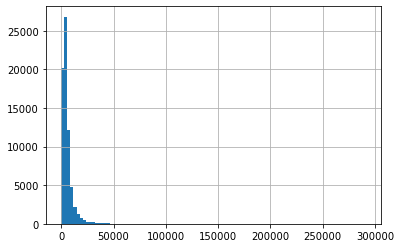

In [38]:
# taxamount
df.taxamount.hist(bins=100)

# remove under 20,000

In [39]:
df = df[df.calculatedfinishedsquarefeet < 9000]

df = df[df.taxamount < 20000]

df.shape

(67822, 22)

In [30]:
def wrangle_zillow():
    ''' 
    '''

    filename = 'zillow.csv'
    
    if os.path.exists(filename):
        print('Reading cleaned data from csv file...')
        return pd.read_csv(filename)
    
    
    query = '''
        SELECT prop.*, 
               pred.logerror, 
               pred.transactiondate, 
               air.airconditioningdesc, 
               arch.architecturalstyledesc, 
               build.buildingclassdesc, 
               heat.heatingorsystemdesc, 
               landuse.propertylandusedesc, 
               story.storydesc, 
               construct.typeconstructiondesc 
               
        FROM properties_2017 prop  
                INNER JOIN (SELECT parcelid,
                                  logerror,
                                  Max(transactiondate) transactiondate 
        FROM predictions_2017 
                GROUP BY parcelid, logerror) pred USING (parcelid)
                
        LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
        LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
        LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
        LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
        LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
        LEFT JOIN storytype story USING (storytypeid) 
        LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
        
        WHERE prop.latitude IS NOT NULL 
        AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
        '''

    url = f"mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow"

    df = pd.read_sql(query, url)
    
    # Single units only
    single_unit = [261, 262, 263, 264, 266, 268, 273, 276, 279]
    df = df[df.propertylandusetypeid.isin(single_unit)]
    
    # Refine
    df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & (df.unitcnt<=1)|df.unitcnt.isnull()]
    
    # Missing Values
    df = handle_missing_values(df)
    
    # Columns to drop
    columns_to_drop = ['id', 'heatingorsystemdesc', 'heatingorsystemtypeid', 'finishedsquarefeet12', 'calculatedbathnbr', 'propertycountylandusecode', 'censustractandblock', 'fullbathcnt', 'propertylandusetypeid', 'propertylandusedesc', 'propertyzoningdesc', 'unitcnt']
    df = df.drop(columns=columns_to_drop)
    
    # Remove nulls for buildingqualitytypeid and lotsizesquarefeet
    df.buildingqualitytypeid.fillna(6.0, inplace= True)
    df.lotsizesquarefeet.fillna(7313, inplace=True)
    
    # Remaining nulls
    df.dropna(inplace=True)
    
    # Outliers
    df = df[df.calculatedfinishedsquarefeet < 9000]
    df = df[df.taxamount < 20000]
    
    print('Downloading data from SQL...')
    print('Saving to .csv')
    return df